In [ ]:
!lscpu

Architecture:                x86_64
  CPU op-mode(s):            32-bit, 64-bit
  Address sizes:             46 bits physical, 48 bits virtual
  Byte Order:                Little Endian
CPU(s):                      2
  On-line CPU(s) list:       0,1
Vendor ID:                   GenuineIntel
  Model name:                Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:              6
    Model:                   79
    Thread(s) per core:      2
    Core(s) per socket:      1
    Socket(s):               1
    Stepping:                0
    BogoMIPS:                4399.99
    Flags:                   fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pg
                             e mca cmov pat pse36 clflush mmx fxsr sse sse2 ss h
                             t syscall nx pdpe1gb rdtscp lm constant_tsc rep_goo
                             d nopl xtopology nonstop_tsc cpuid tsc_known_freq p
                             ni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2ap
                   

/tmp/ipython-input-2856092981.py:46: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date()


Synthetic sales generated: 1,000,000 rows in 5.72s
Dataset saved: /content/sales_dataset.csv
Mapping with 1 processes over 100 batches (~10000 rows/batch)...
Map phase: 2.55s
Shuffle: 0.00s | Reduce: 0.0001s

Top categories by revenue:
      category       revenue    units  avg_price
0  Electronics  1.020758e+08  1066095  95.747338
1         Home  4.607600e+07   479894  96.012878
2       Sports  2.901717e+07   304163  95.400060
3         Toys  2.082129e+07   216682  96.091476
4        Books  1.592451e+07   166125  95.858584
5       Beauty  1.316415e+07   136483  96.452643
6      Grocery  1.088396e+07   114368  95.166173
7     Clothing  9.302226e+06    97418  95.487750

Results saved: /content/sales_results_by_category.csv


,category,revenue,units,avg_price
0,Electronics,1.020758e+08,1066095,95.747338
1,Home,4.607600e+07,479894,96.012878
2,Sports,2.901717e+07,304163,95.400060
3,Toys,2.082129e+07,216682,96.091476
4,Books,1.592451e+07,166125,95.858584
5,Beauty,1.316415e+07,136483,96.452643
6,Grocery,1.088396e+07,114368,95.166173
7,Clothing,9.302226e+06,97418,95.487750


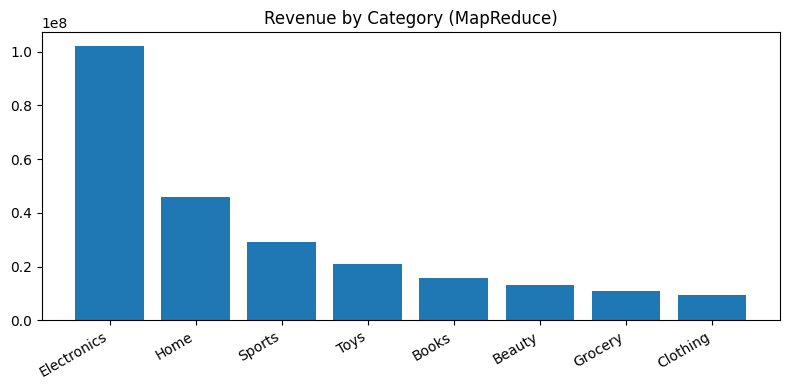


✅ Done. You can download the files below:
- Dataset: /content/sales_dataset.csv
- Results: /content/sales_results_by_category.csv


In [ ]:
# Applied MapReduce in Python (Colab-ready): Sales analytics at scale
# ------------------------------------------------------------------
# What it does
# - Generates a synthetic transaction dataset (date, user_id, product_id, category, price, qty)
# - Runs a MapReduce pipeline with multiprocessing to compute:
#     1) Revenue by category
#     2) Units sold by category
# - Displays a ranked table and a bar chart
# - Saves dataset and results to CSV files you can download
#
# You can tweak the PARAMETERS section to scale up or change behavior.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from multiprocessing import Pool, cpu_count
from time import perf_counter
from datetime import datetime, timedelta
import os

# For nice, spreadsheet-like table display in the UI
# from caas_jupyter_tools import display_dataframe_to_user

# ---------------------
# PARAMETERS (editable)
# ---------------------
N_TX = 10_00_000            # number of transactions
N_USERS = 20_000          # distinct users
N_PRODUCTS = 5_000        # distinct products
CATEGORIES = ["Electronics", "Home", "Sports", "Toys", "Books", "Beauty", "Grocery", "Clothing"]
DAYS = 60                 # transactions span the last N days
AVG_QTY = 1.6             # average quantity per transaction
PRICE_MIN, PRICE_MAX = 3.0, 600.0
ZIPF_SKEW = 1.15          # >1 biases top categories/products to sell more
PROCESSES = max(1, min(8, cpu_count() // 2))
CHUNK_SIZE = 10_000       # transactions per mapper task

np.random.seed(7)

# ---------------------------
# 1) SYNTHETIC DATA GENERATOR
# ---------------------------
def generate_synthetic_sales(n_tx):
    # Dates
    end_date = datetime.utcnow().date()
    start_date = end_date - timedelta(days=DAYS-1)
    # Uniform day offsets, then convert to dates
    day_offsets = np.random.randint(0, DAYS, size=n_tx)
    dates = np.array([start_date + timedelta(days=int(d)) for d in day_offsets], dtype="datetime64[D]")

    # Users & products
    user_ids = np.random.randint(1, N_USERS + 1, size=n_tx)
    # Sample products with Zipf-like bias
    ranks = np.arange(1, N_PRODUCTS + 1)
    prod_weights = 1 / (ranks ** ZIPF_SKEW)
    prod_probs = prod_weights / prod_weights.sum()
    product_ids = np.random.choice(np.arange(1, N_PRODUCTS + 1), size=n_tx, p=prod_probs)

    # Categories with Zipf-like bias
    cat_ranks = np.arange(1, len(CATEGORIES) + 1)
    cat_weights = 1 / (cat_ranks ** ZIPF_SKEW)
    cat_probs = cat_weights / cat_weights.sum()
    categories = np.random.choice(CATEGORIES, size=n_tx, p=cat_probs)

    # Prices and quantities
    prices = np.random.lognormal(mean=np.log(60), sigma=1.0, size=n_tx)
    prices = np.clip(prices, PRICE_MIN, PRICE_MAX)
    # Quantities: geometric-like around AVG_QTY
    p = 1.0 / (AVG_QTY + 1.0)
    qty = np.random.geometric(p, size=n_tx)
    qty = np.clip(qty, 1, 10)

    df = pd.DataFrame({
        "date": dates,
        "user_id": user_ids,
        "product_id": product_ids,
        "category": categories,
        "price": prices.round(2),
        "qty": qty
    })
    return df

t0 = perf_counter()
sales = generate_synthetic_sales(N_TX)
t1 = perf_counter()
print(f"Synthetic sales generated: {len(sales):,} rows in {t1 - t0:.2f}s")

# Save dataset for inspection
# Changed save path to /content/
os.makedirs("/content", exist_ok=True)
data_path = "/content/sales_dataset.csv"
sales.to_csv(data_path, index=False)
print(f"Dataset saved: {data_path}")

# ----------------------------------
# 2) MAP / SHUFFLE / REDUCE PIPELINE
# ----------------------------------
def chunk_indices(n, size):
    for start in range(0, n, size):
        yield start, min(start + size, n)

def mapper_category_agg(args):
    """
    Receives (start, end) row indices; returns dict(category -> [revenue_sum, units_sum])
    """
    start, end, df = args
    acc = {}
    view = df.iloc[start:end]
    # Compute revenue = price * qty
    for cat, price, qty in zip(view["category"].values, view["price"].values, view["qty"].values):
        sc = acc.setdefault(cat, [0.0, 0])
        sc[0] += float(price) * int(qty)  # revenue
        sc[1] += int(qty)                # units
    return acc

def shuffle_merge(partials):
    merged = {}
    for part in partials:
        for k, (rev, units) in part.items():
            sc = merged.setdefault(k, [0.0, 0])
            sc[0] += rev
            sc[1] += units
    return merged

def reducer_identity(merged):
    return merged

# Prepare tasks
tasks = [(s, e, sales) for (s, e) in chunk_indices(len(sales), CHUNK_SIZE)]

print(f"Mapping with {PROCESSES} processes over {len(tasks)} batches (~{CHUNK_SIZE} rows/batch)...")
t2 = perf_counter()
with Pool(processes=PROCESSES) as pool:
    partials = pool.map(mapper_category_agg, tasks)
t3 = perf_counter()
print(f"Map phase: {t3 - t2:.2f}s")

t4 = perf_counter()
grouped = shuffle_merge(partials)
t5 = perf_counter()
final = reducer_identity(grouped)
t6 = perf_counter()
print(f"Shuffle: {t5 - t4:.2f}s | Reduce: {t6 - t5:.4f}s")

# --------------------------
# 3) RESULTS & VISUALIZATION
# --------------------------
res = pd.DataFrame(
    [(k, v[0], v[1]) for k, v in final.items()],
    columns=["category", "revenue", "units"]
).sort_values("revenue", ascending=False).reset_index(drop=True)

res["avg_price"] = res["revenue"] / res["units"]
print("\nTop categories by revenue:")
print(res.head(10))

# Save results
# Changed save path to /content/
res_path = "/content/sales_results_by_category.csv"
res.to_csv(res_path, index=False)
print(f"\nResults saved: {res_path}")

# Display table to user
display(res)

# Plot bar chart
plt.figure(figsize=(8, 4))
plt.bar(res["category"], res["revenue"])
plt.xticks(rotation=30, ha="right")
plt.title("Revenue by Category (MapReduce)")
plt.tight_layout()
plt.show()

print("\n✅ Done. You can download the files below:")
print(f"- Dataset: {data_path}")
print(f"- Results: {res_path}")